# Implementation of Deep Convolutional GANs
In this notebook, you're going to create another GAN using the MNIST dataset. You will implement a Deep Convolutional GAN (DCGAN), a very successful and influential GAN model developed in 2015.

*Note: [DCGAN](https://arxiv.org/pdf/1511.06434v1.pdf) is the paper if you are interested! It might look dense now, but soon you'll be able to understand many parts of it :)*

In [1]:
!pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [8]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel = 1, num_classes = 1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y = None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

**Instructions**: The discriminator class is already given to you. You have to write the generator class as per the DCGAN architecture given below:
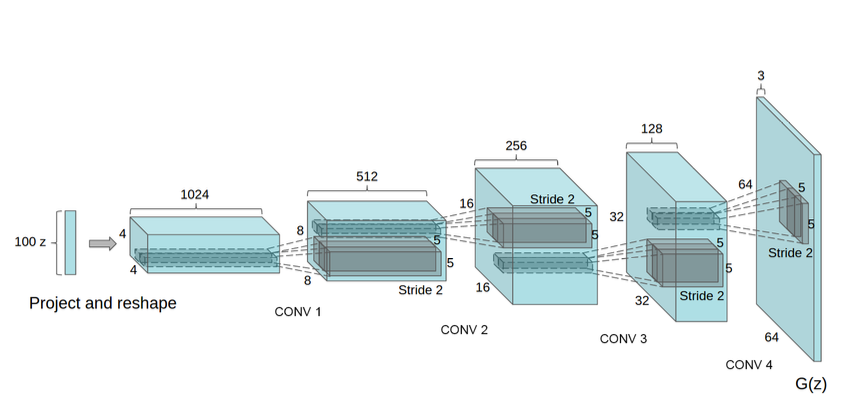

In [11]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_noise_vector = 100, num_classes = 784, num_of_feature_map = 64, num_channels = 3):
        super(Generator, self).__init__()

        # Write your code here
        self.conv = nn.Sequential(
            # This scaling factor of 8 which is being multiplied with num_of_feature_map is a design choice
            # and can be adjusted based on the specific requirements of the model and the dataset.
            nn.ConvTranspose2d(in_channels = 100, out_channels = 64 * 8, kernel_size = 4, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = 64 * 8, out_channels = 64 * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = 64 * 4, out_channels = 64 * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = 64 * 2, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = 64, out_channels = 3, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.Tanh()  # Output will be in the range [-1, 1]

        )

    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        return y_

In [12]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [14]:
mnist = datasets.MNIST(root = '../data/', train = True, transform = transform, download= True)

100%|██████████| 9912422/9912422 [00:00<00:00, 80046884.13it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 65408042.02it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24982539.39it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4864792.84it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [15]:
batch_size = 64

In [16]:
data_loader = DataLoader(dataset = mnist, batch_size = batch_size, shuffle = True, drop_last = True)

In [17]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr = 0.001, betas = (0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr = 0.001, betas = (0.5, 0.999))

In [18]:
max_epoch = 30 # need more than 20 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [19]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [ ]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            os.makedirs('samples', exist_ok = True)

            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

## Visualize Sample

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap = 'gray')

**Instructions:** Save the trained parameters of the generator and discriminator.

# **This code should be in epoch loop to save all the params at the end of every epoch**

In [ ]:
# Saving Model Configurations and Paramaters

  # Write your code here

  # Save models and configuration at the end of each epoch
    if epoch % save_interval == 0:
        # Save the generator (G) and discriminator (D) state dictionaries
        torch.save(G.state_dict(), 'generator_checkpoint_epoch{}.pth'.format(epoch))
        torch.save(D.state_dict(), 'discriminator_checkpoint_epoch{}.pth'.format(epoch))

        # Save the model configuration (optional)
        model_config = {
            'n_noise': n_noise,
            'batch_size': batch_size,
            # optional parameters.......
        }
        with open('model_config.json', 'w') as f:
            json.dump(model_config, f)

